# Personalized medicine and cancer treatment

## Background

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

The project is to distinguish the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).  And to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

For example, the text description for CBL gene's variant w802 is " Abstract Background  Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC. ...". The pathologist classified the variant as class 2 according to the text. It should be related to tumor growth. Our task is to automate the classification process.

The data set has four variables which are genes, variation, class and text. The genes are cancer related genes which means they are overexpressed or low expressed in cancer patients. Variation are the same types of cancer related genes with minor difference of gene structure. For example, CBL is lung cancer related genes. It has at least four types such as W802, Q249E, N454D and L399V. Variation W802, Q249E, N454D and L399V are all CBL genes but just has some minor difference in their gene structure.

The minor structure changes of gene, or so called variation(mutations), will contribute to tumor growth or have no effect on the tumor. The variable 'Class' in the data set is the classification of the gene's variation according to whether it helps the tumor growth or not. Knowing the gene variants belong to which class can help the doctor to find the best suitable treatment for different cancer patients. It is called personized medicine when Patients with same type of disease but are treated with different medicine due their genetic testing.


In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords

## Overview of the data

In [2]:
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"], encoding="utf-8")
test_text_df = pd.read_csv("test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"], encoding="utf-8")
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


In [3]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
print("For training data, there are a total of", len(train_variants_df.ID.unique()), "IDs,", end='')
print(len(train_variants_df.Gene.unique()), "unique genes,", end='')
print(len(train_variants_df.Variation.unique()), "unique variations and ", end='')
print(len(train_variants_df.Class.unique()),  "classes")

print('\n' + "For test data, there are a total of", len(test_variants_df.ID.unique()), "IDs,", end='')
print(len(test_variants_df.Gene.unique()), "unique genes,", end='')
print(len(test_variants_df.Variation.unique()), "unique variations")

For training data, there are a total of 3321 IDs,264 unique genes,2996 unique variations and 9 classes

For test data, there are a total of 5668 IDs,1397 unique genes,5628 unique variations


##                                      Explanatory Data Analysis

### I. Gene distribution overview

#### Top 10 occurred genes 

In [6]:
gene_group = train_variants_df.groupby("Gene")['ID'].count()
print("Genes with maximal occurrences in training data"+"\n", gene_group.sort_values(ascending=False)[:10])

gene_group_test = test_variants_df.groupby("Gene")['ID'].count()
print("\n" + "Genes with maximal occurrences in test data" +"\n", gene_group_test.sort_values(ascending=False)[:10])

Genes with maximal occurrences in training data
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: ID, dtype: int64

Genes with maximal occurrences in test data
 Gene
F8       134
CFTR      57
F9        54
G6PD      46
GBA       39
PAH       38
AR        38
CASR      37
ARSA      30
BRCA1     29
Name: ID, dtype: int64


The top ten genes in training data are different from that of the test data. The only common top ten gene is BRCA1. It shows the gene distributions in the training and test data are not the same.

#### Top 10 genes of training set scatter plot

In [7]:
# Occurence of top ten genes in training set
gene_group_re = gene_group.reset_index()
y1 = gene_group_re.sort_values(by='ID', ascending=False)[:10]
y1['rank'] = [1,2,3,4,5,6,7,8,9,10]

# Occurence in test set for genes which are top_10 genes in training set  

top10_train_gene_test = test_variants_df[test_variants_df.Gene.isin(list(gene_group.sort_values(ascending=False)[:10].index))]
top10_train_gene_test_group = top10_train_gene_test.groupby('Gene')['ID'].count()
y2 = top10_train_gene_test_group.reset_index()

dff = y2.merge(y1, on='Gene', how='inner')
dff.rename(columns={'rank' : 'Gene', 'ID_x' :'frequency_test', 'ID_y':'frequency_train'}, inplace=True)
dff

,Gene,frequency_test,frequency_train,Gene
0,ALK,8,69,8
1,BRAF,11,93,7
2,BRCA1,29,264,1
3,BRCA2,16,125,5
4,EGFR,16,141,3
5,ERBB2,7,69,9
6,KIT,11,99,6
7,PDGFRA,7,60,10
8,PTEN,20,126,4
9,TP53,19,163,2


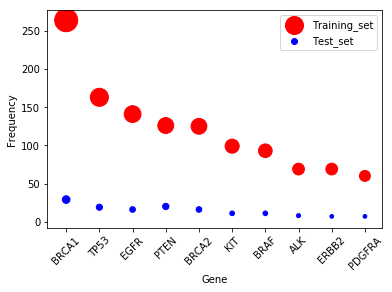

In [8]:
ticks = [1,2,3,4,5,6,7,8,9,10]
labels = y1['Gene'].values

ax = dff.plot(kind='scatter', x='Gene', y='frequency_train', color='Red', s=2*dff.frequency_train.values, label='Training_set')

dff.plot(kind='scatter', x='Gene', y='frequency_test', color='Blue', s=2*dff.frequency_test.values,label='Test_set', ax=ax)

ax.set_xticks(ticks)
ax.set_xticklabels(labels, minor=False, rotation=45)
ax.set_ylabel('Frequency')

### II. Gene distribution in classes

#### Gene frequency in nine mutation classes

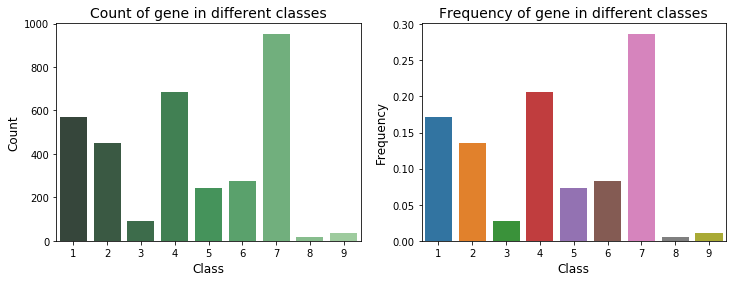

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(12,4))

sns.countplot(x="Class", data=train_variants_df, palette="Greens_d", ax=ax1)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_title("Count of gene in different classes", fontsize=14)

y1 = train_variants_df.groupby("Class")['ID'].count().reset_index()
sns.barplot(x="Class", y=y1.ID / y1.ID.sum(),data=y1, ax=ax2)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_title("Frequency of gene in different classes", fontsize=14)

Gene's frequency peaks at class 7. Lowest gene occurrence class are 8 and 9. Middle high class are class 1, 2 and 4. Middle low class are class 3, 5 and 6.

#### Top seven genes distribution in different classes

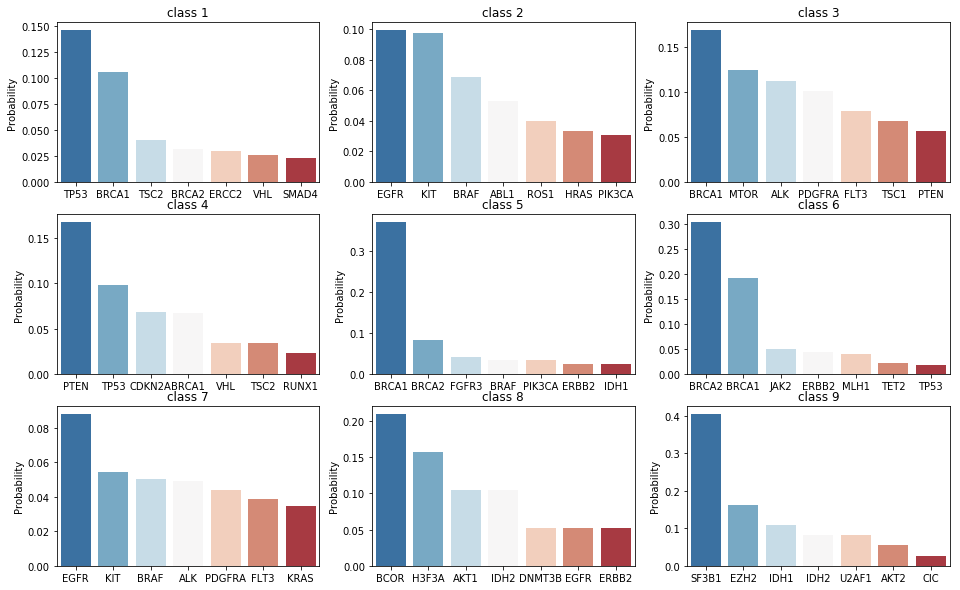

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,10))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        figure = sns.barplot(x="Gene", y=sorted_gene_group_top_7.ID / gene_count_grp.ID.sum(), 
                             data=sorted_gene_group_top_7,palette="RdBu_r", ax=axs[i][j])
        figure.set_title('class ' + str((i*3+j)+1))
        figure.set_xlabel('')
        figure.set_ylabel('Probability')

EGFR rank first in class 2 and 7. 

BRCA1 ranks first in class 3, 5 and ranks second in class 6. 

BRCA2 ranks first in class 6 and ranks second in 5.

And these three genes are among the top ten occurred genes in training data.

### III. Variations overview

#### Top 10 variations 

In [11]:
variation_group = train_variants_df.groupby("Variation")['Variation'].count()
print("Variations with maximal occurrences" + "\n", variation_group.sort_values(ascending=False)[:10])

variation_group_test = test_variants_df.groupby("Variation")['Variation'].count()
print("\n" + "Variations with maximal occurrences" + "\n", variation_group_test.sort_values(ascending=False)[:10])

Variations with maximal occurrences
 Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
E17K                     3
T58I                     3
Q61L                     3
Q61R                     3
Name: Variation, dtype: int64

Variations with maximal occurrences
 Variation
Truncating Mutations    18
Deletion                14
Amplification            8
Fusions                  3
G44D                     2
H1464P                   1
H12Q                     1
H132P                    1
H136R                    1
H137L                    1
Name: Variation, dtype: int64


#### Top 10 variations' scatter plot

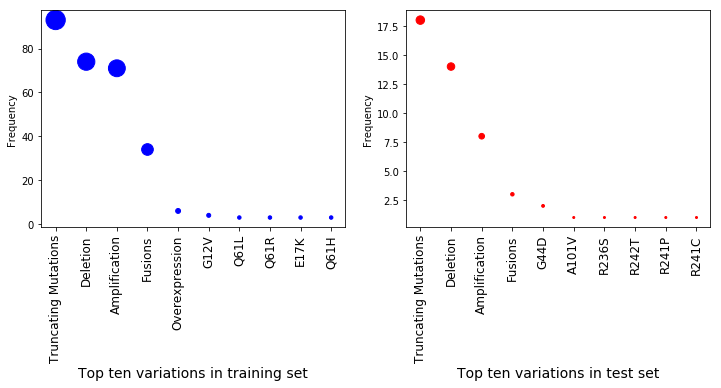

In [12]:
y1 = train_variants_df.groupby("Variation")['ID'].count().reset_index().sort_values(by='ID',ascending=False)[:10]
y1['rank'] = [1,2,3,4,5,6,7,8,9,10]

y2 = test_variants_df.groupby("Variation")['ID'].count().reset_index().sort_values(by='ID',ascending=False)[:10]
y2['rank'] = [1,2,3,4,5,6,7,8,9,10]

ticks = [1,2,3,4,5,6,7,8,9,10]
labels1 = y1['Variation'].values
labels2 = y2['Variation'].values

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(12,4))

y1.plot(kind='scatter', x='rank', y='ID', color='Blue', s=4*y1.ID.values, fontsize=10,ax=ax1)
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels1, minor=False, rotation=90, fontsize=12)
ax1.set_xlabel('Top ten variations in training set', fontsize=14)
ax1.set_ylabel('Frequency')

y2.plot(kind='scatter', x='rank', y='ID', color='Red', s=4*y2.ID.values,fontsize=10, ax=ax2)
ax1.set_xticks(ticks)
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels2, minor=False, rotation=90, fontsize=12)
ax2.set_xlabel('Top ten variations in test set',fontsize=14)
ax2.set_ylabel('Frequency')

Top four variations are same in train and test data set. They are Truncating mutations, Deletion, Amplification and Fusions.

But the counts of top four variations in training data are much higher than that in test data. 

It shows the variation distributions in training data and test data are of much difference.

### IV. Variation and class

#### Top 10 variations' class distribution

In [13]:
top_10_variants = pd.DataFrame(variation_group.sort_values(ascending=False)[:10])
variants_slice = train_variants_df[train_variants_df['Variation'].isin(list(top_10_variants.index))]
variants_slice.shape

(294, 4)

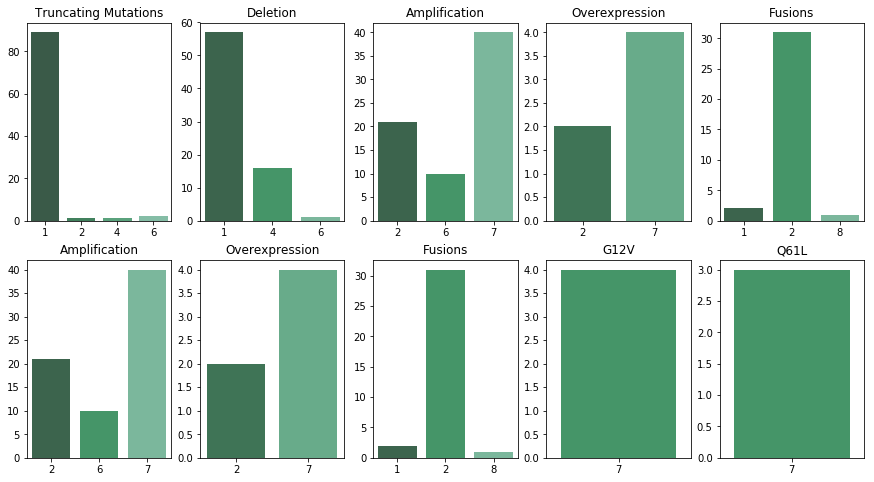

In [14]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,8))

for i in range(2):
    for j in range(5):
        variation_count_grp = variants_slice[variants_slice['Variation'] == variants_slice.Variation.unique() [(i*2+j)]].groupby('Class')['ID'].count().reset_index()
        figure = sns.barplot(x="Class", y="ID", data=variation_count_grp, palette="BuGn_d", ax=axs[i][j])
        figure.set_title(variants_slice.Variation.unique() [(i*2+j)])
        figure.set_xlabel('')
        figure.set_ylabel('')

Top one and top two variations are Truncating mutations and Deletion. They are both located in Class 1, 4 and 6. And Truncating mutations is also in class 2.

Top three and top four variations are Amplification and Fusions. They are both located in Class 2 and 7. And Amplification is also in class 6.

#### Variation distribution in different classes

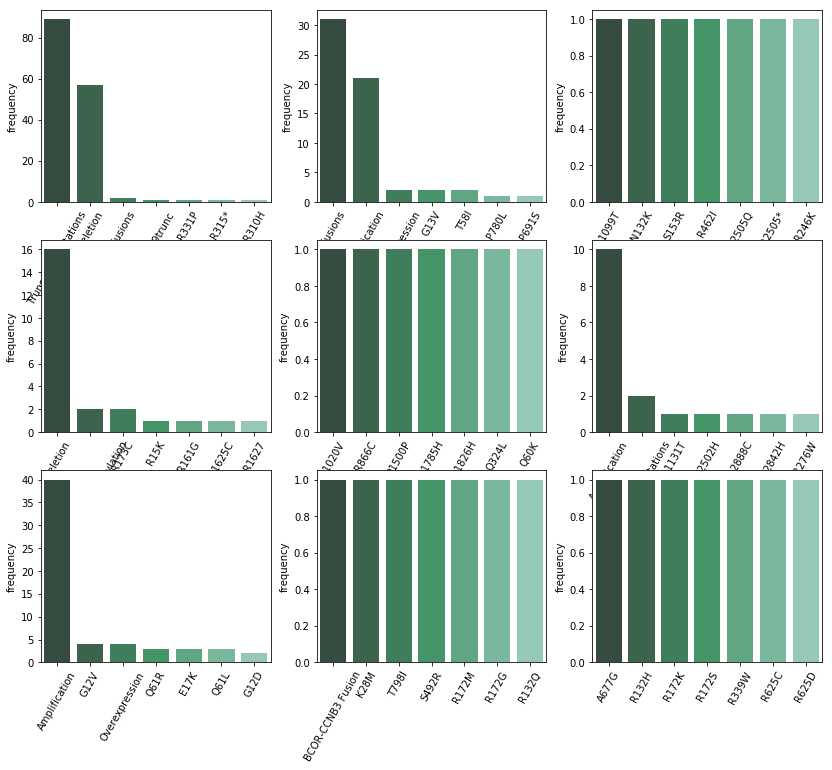

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(14,12))

for i in range(3):
    for j in range(3):
        variation_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Variation')["ID"].count().reset_index()
        sorted_variation_group = variation_count_grp.sort_values('ID', ascending=False)
        sorted_variation_group_top_7 = sorted_variation_group[:7]
        figure = sns.barplot(x="Variation", y="ID", data=sorted_variation_group_top_7, palette="BuGn_d", ax=axs[i][j])
        figure.set_xlabel('')
        figure.set_ylabel('frequency')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=10)

Class 3, 5, 8, 9 the maximum gene variation is 1. 

Truncating mutations ranks first in class 1 and second in class 6 (class location 1,2,4,6).

Deletion ranks first in class 4 and second in class 1 (class location 1,4,6).

Amplification ranks first in class 6 and 7. And it ranks second in class 2 (class location 2,6,7).

Fusions ranks first in class 2 (class location 2,7).

### V. Text length overview

In [16]:
train_text_df.loc[:, 'Text_count']  = train_text_df["Text"].apply(lambda x: len(x.split()))
train_text_df.head()

,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [17]:
test_text_df.loc[:, 'Text_count']  = test_text_df["Text"].apply(lambda x: len(x.split()))
test_text_df.head()

,ID,Text,Text_count
0,0,2. This mutation resulted in a myeloproliferat...,7417
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,4710
2,2,Vascular endothelial growth factor receptor (V...,11080
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,8380
4,4,Abstract Retinoblastoma is a pediatric retina...,11159


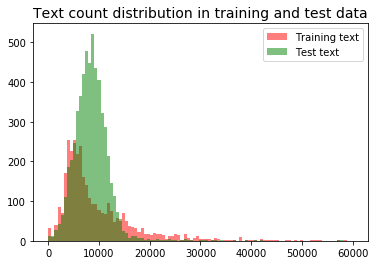

In [18]:
x = train_text_df['Text_count']
y = test_text_df['Text_count']
bins = np.linspace(0, 60000, 100)

plt.hist(x, bins, alpha=0.5, label='Training text', color='red')
plt.hist(y, bins, alpha=0.5, label='Test text', color='green')
plt.legend(loc='upper right')
plt.title('Text count distribution in training and test data', fontsize=14)
plt.show()

The most frequent text count in training set is about 5000 while that in test set is about 10000. The text amount distribution in both training and test data set are close to normal distribution.

#### Combining the train_variants file with train_text file

In [19]:
train_full = train_variants_df.merge(train_text_df, how="inner", left_on="ID", right_on="ID")
train_full[train_full["Class"]==1].head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cord–stromal tumors and germ-cell tumors a...,2710
38,38,DICER1,D1709A,1,Sex cord–stromal tumors and germ-cell tumors a...,2710


In [20]:
count_grp = train_full.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,9450.299296,6516.412101,1.0,4973.0,7305.0,12873.5,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.0,6810.0,12220.0,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.0,5572.0,7415.0,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.0,6351.0,11537.0,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.0,6463.0,9513.5,24226.0
6,275.0,7184.120000,3836.912865,1.0,4505.5,6587.0,7847.0,24609.0
7,953.0,11442.867786,10111.940846,1.0,4871.0,8254.0,14620.0,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.0,11253.0,15535.0,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.0,10930.0,15797.0,45177.0


### VI. Text length distribution by class

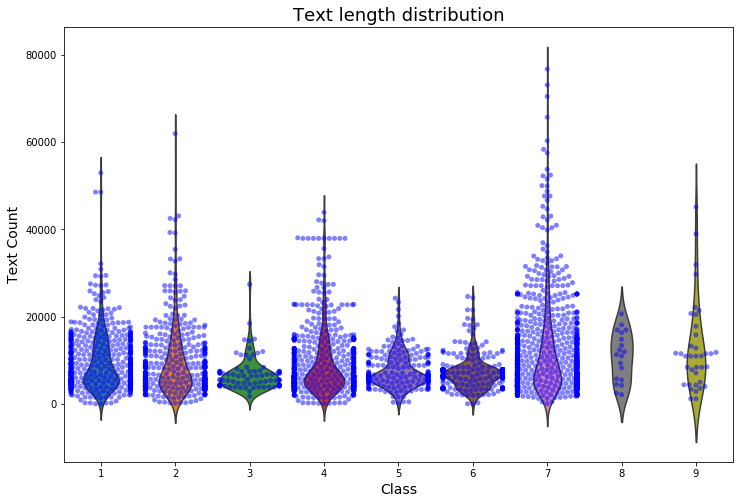

In [21]:
plt.figure(figsize=(12,8))
gene_count_grp = train_full.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=train_full, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=train_full, color="b", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

Text  count in Class 7 ranges from 1 to nearly 80000. It is the largest range among the nine classes. Class 8 and 9 have the smallest ranges. Class1, 2 and 4 have high middle text range. Class 3, 5 and 6 have low middle class text range. The text count distribution is similar to the gene occurrence distribution in different classes.

### VII. Mean text count by genes in different classes

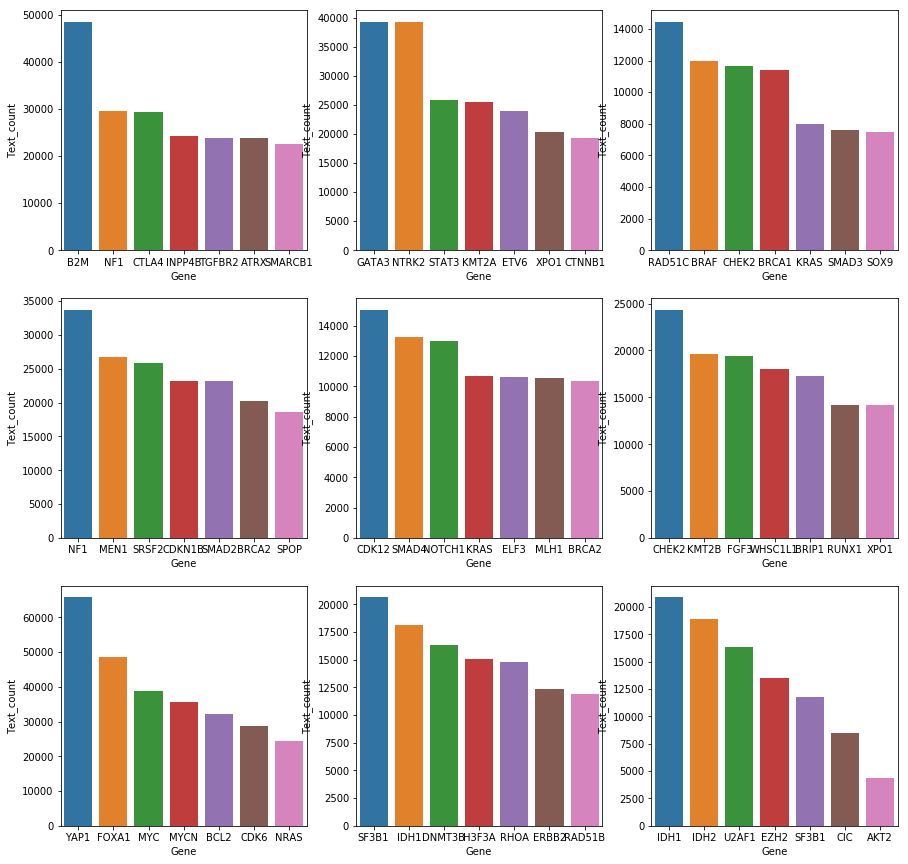

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_full[train_full["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

This plot shows the top seven mean text count for genes in different classes.

BRCA1 and BRCA2 are among the top ten occurred genes. And they are also in the top seven text count genes in some classes.

### VIII. Top 10 TF-IDF features in class 2 and 7

We need to know more about text. 

Gene distribution analysis shows top one gene EGFR ranks first in class 2 and 7. 

Variation distribution analysis shows Amplification and Fusions (top 2 variations) mainly located in class 2 and 7. What’s more, Amplification ranks first in class 7 and Fusions ranks first in class 2.

The above fact give us an impression that class 2 and class 7 are highly similar in both gene occurrence and variation distribution. What are about their top 10 text features?

Tf-idf is known as one good technique to use for text transformation and get good features out of text for training our machine learning model. Let’s see the top 10 text features in class 2 and class 7.

In [23]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    #labels = np.unique(y)
    labels = [2,7]
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(8, 30), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [24]:
tfidf = TfidfVectorizer(min_df=5, stop_words = 'english', max_df=0.75).fit(train_full["Text"])

Xtr = tfidf.fit_transform(train_full["Text"])
y = train_full["Class"]
features = tfidf.get_feature_names()
top_dfs = top_feats_by_class(Xtr, y, features)

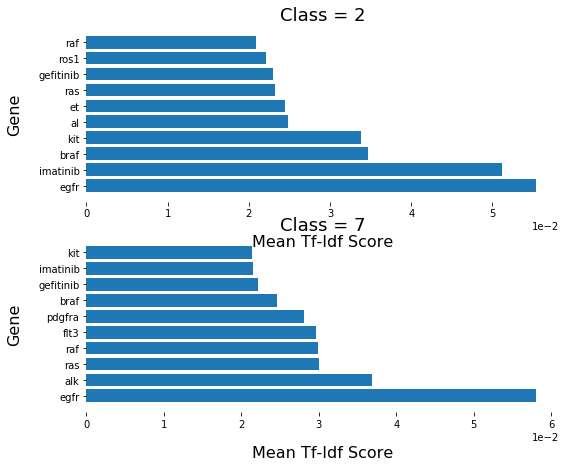

In [25]:
plot_tfidf_classfeats_h(top_dfs)

There are seven common text features in the two classes. There are 70% similarity for the top 10 text features between class 2 and class 7! But the common text features' value are different in the two classes.

For example, word 'egfr' contributes as a strong indicator for both classes 2 & 7 and its value does not change much between them - it adds only a little higher score for class 7. While word 'braf' TF-IDF weights is 3.5 in class 2 and that of class 7 is about 2.5. It means 'braf' contributes more to class 2 than to 7.

#### Find the missing values of Text 

In [26]:
train_full[train_full["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,null,1
1277,1277,ARID5B,Truncating Mutations,1,null,1
1407,1407,FGFR3,K508M,6,null,1
1639,1639,FLT1,Amplification,6,null,1
2755,2755,BRAF,G596C,7,null,1


In [27]:
# delete missing values
df = train_full[train_full.Text_count != 1]
df.shape

(3316, 6)

## Base model building without text processing

In [28]:
slice = df.groupby('Variation')['ID'].count().reset_index().sort_values('ID', ascending=False)
slice.head(6)

,Variation,ID
2626,Truncating Mutations,92
473,Deletion,74
149,Amplification,70
807,Fusions,34
1724,Overexpression,6
844,G12V,4


In [29]:
base_df = df[df.Variation.isin(['Truncating Mutations', 'Deletion', 'Amplification','Fusions','Overexpression','G12V'])]
base_df = base_df[['Gene','Variation','Class']]

In [31]:
X = pd.get_dummies(base_df, columns=['Gene','Variation']).values
Y = base_df.Class.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(224, 205) (224,)
(56, 205) (56,)


In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train, Y_train)
    # Create the predicted tags: pred
pred = clf.predict(X_test)
    # Calculate the accuracy score: score
score = metrics.accuracy_score(Y_test, pred)
print("Test accuracy:")
print(score)

Test accuracy:
0.928571428571


In the basic model we used variable 'Gene' and 'Variation' as predictors. There are nearly three thousands categories of variation and we select the variations which count more or equal to 5. With the logistic regression classifier we get test accuracy is 0.93.

## Text processing and Model building

### I. Bag of words and TF-IDF

#### Getting word vector

In [29]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.Text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.Class.values
    return X, y

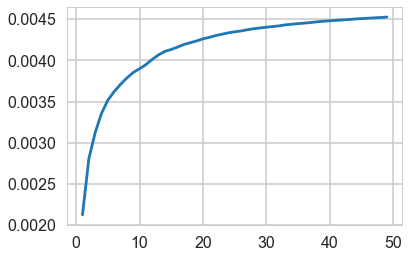

In [34]:
#set up seaborn style
sns.set_style("whitegrid")
sns.set_context("poster")

# elbow method to find min_df
vectorizer = CountVectorizer(min_df=1)
X,y = make_xy(train_full,vectorizer=vectorizer)
dfs = []
for i in range(1,50):
    vectorizer = CountVectorizer(max_df=i)
    X,y = make_xy(train_full,vectorizer=vectorizer)
    dfs.append(X.shape[1])
dfs_percent = [df/31690362 for df in dfs]
plt.plot(range(1,50),dfs_percent)

When the min_df equals 4 or 5 the curve's increase become slowly.

In [35]:
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(df['Text'], y, test_size=0.33, random_state=53)

In [36]:
def word_vect(vectorizer):
    train = vectorizer.fit_transform(X_train.values)
    test = vectorizer.transform(X_test.values)
    return vectorizer,train,test

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer,count_train,count_test = word_vect(vectorizer = CountVectorizer(min_df=4, stop_words='english'))
print('features length of counter vectorizer: ', len(count_vectorizer.get_feature_names()))

features length of counter vectorizer:  46288


In [38]:
tfidf_vectorizer,tfidf_train,tfidf_test = word_vect(vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7))
print('features length of TF_IDF vectorizer: ', len(tfidf_vectorizer.get_feature_names()))

features length of TF_IDF vectorizer:  131056


### Model building

In [39]:
#Build a cross validation predict function 
def cross_pred(clf, x_train):
    cv_scores = []
    cv_logloss = []

    kfold = model_selection.KFold(n_splits=10, random_state=53)
 
    # fit the model with training set
    #scores = model_selection.cross_val_predict(clf, train, y_train, cv=kfold)
    #cv_scores.append(scores.mean()*100)
    #print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))
 
    # predict logloss on testing set
    preds_prob = model_selection.cross_val_predict(clf, x_train, y_train, cv=kfold, method="predict_proba")
    cv_logloss.append(metrics.log_loss(y_train, preds_prob))
    print("Cross validate log loss %0.2f" % ((metrics.log_loss(y_train, preds_prob)).mean()))\
    
    # predict on testing set
    preds = model_selection.cross_val_predict(clf, x_train, y_train, cv=kfold)
    cv_scores.append(metrics.accuracy_score(y_train, preds))
    print("Cross validate accuracy %0.2f" % ((metrics.accuracy_score(y_train, preds)).mean()))
    return cv_scores, cv_logloss

#### Naive Bays without tuning

In [40]:
cross_pred(clf=MultinomialNB(), x_train=count_train)

Cross validate log loss 13.53
Cross validate accuracy 0.60


([0.59612787032868075], [13.530816139452792])

In [41]:
cross_pred(clf=MultinomialNB(), x_train=tfidf_train)

Cross validate log loss 1.74
Cross validate accuracy 0.52


([0.5227375056280954], [1.7392348305306935])

The accuray of Naive Bays with Counter vector is 0.60 and higher than that of model with TF-IDF. But the log loss of TF-IDF is 1.74 and far less than that of modle with Counter vector. It means TF-IDF has less false classification. As for the accuracy we can tune the hyperparameter to increase it.

#### TF-IDF and Naive Bays tuning

In [52]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',min_df=4)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
param_dist = {
    'tfidf__max_df': [0.25, 0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}


rand = model_selection.RandomizedSearchCV(pipeline, param_dist, cv=2, scoring='accuracy', n_iter=5, random_state=5)

# fit
rand.fit(X_train, y_train)

# scores
print(rand.grid_scores_)
print("Best parameters set:")
print(rand.best_estimator_.steps)

[mean: 0.59388, std: 0.01043, params: {'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.5, 'clf__estimator__alpha': 0.01}, mean: 0.60333, std: 0.01181, params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 0.25, 'clf__estimator__alpha': 0.01}, mean: 0.60468, std: 0.00596, params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 0.25, 'clf__estimator__alpha': 0.001}, mean: 0.59433, std: 0.01088, params: {'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.25, 'clf__estimator__alpha': 0.01}, mean: 0.59433, std: 0.00097, params: {'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.25, 'clf__estimator__alpha': 0.001}]
Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=4,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False

C:\Users\yepeng\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [42]:
tfidf_vectorizer,tfidf_train,tfidf_test = word_vect(vectorizer = TfidfVectorizer(stop_words='english', 
                                                                                 max_df=0.25, min_df=4, ngram_range=(1, 2)))
print('features length of TF_IDF vectorizer: ', len(tfidf_vectorizer.get_feature_names()))

features length of TF_IDF vectorizer:  600802


In [43]:
cross_pred(clf=MultinomialNB(alpha=0.001), x_train=tfidf_train)

Cross validate log loss 6.51
Cross validate accuracy 0.62


([0.62044124268347589], [6.5130061007145343])

Using the tuned hyper parameters, Naive bays with TF-IDF model accuracy in validate set increased from 0.52 to 0.62. Great increase! The tuned Naive Bays with TF-IDF has higher accuracy and lower log loss than the model with Counter vector. So in the following model building we will choose TF-IDF as the way we get word vector.

#### Confusion matrix of Naive bays with TF-IDF model in test data set

In [39]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.25, min_df=4, ngram_range=(1,2))

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

nb_classifier = MultinomialNB(alpha=0.001)
    # Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)
    # Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)
    # Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print("Test accuracy:")
print(score * 100)

 # Calculate logloss
preds_prob = nb_classifier.predict_proba(tfidf_test)
print("Test log loss %0.2f" % (metrics.log_loss(y_test, preds_prob)))

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

Test accuracy:
58.8127853881
Test log loss 7.09
[[107   1   2  32  24   3  12   1   0]
 [  5  81   2   4   5   0  56   0   0]
 [  2   0  21   4   5   0   2   0   0]
 [ 51   9  10 121  20   3   9   0   2]
 [ 19   2   4   4  38   7   7   0   0]
 [ 18   2   1   0   6  56  10   0   0]
 [  3  60  15   2  15   1 204   0   1]
 [  0   1   0   0   1   1   1   2   2]
 [  2   0   0   0   1   0   1   0  14]]


Test accuracy is 0.58 and is lower than that of cross validate accuracy 0.62. And the log loss of test set is 7.09 and higer than that of cross validate set 6.51.Log Loss quantifies the accuracy of a classifier by penalizing false classifications. Minimizing the Log Loss is basically equivalent to maximizing the accuracy of the classifier.

Confusion matrix shows class 7 is over predicted. The majority over predicted class is class 7. In the top 10 TF-IDF features analysis we can see class 7 and class 2 have 70% similarity in the top 10 features. It may be one of the reasons that there are 57 class 2 mutations predicted as class 7.

#### Random Forest hyperparameter tuning

In [51]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [100, 500, 1000, 2000],
           "max_depth" : [1, 5, 10, 15],
           "min_samples_leaf" : [10, 50, 100]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(tfidf_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 1000}


In [44]:
tfidf_vectorizer,tfidf_train,tfidf_test = word_vect(vectorizer = TfidfVectorizer(stop_words='english', 
                                                                                 max_df=0.75, min_df=4))
print('features length of TF_IDF vectorizer: ', len(tfidf_vectorizer.get_feature_names()))

features length of TF_IDF vectorizer:  46125


In [45]:
cross_pred(clf=RandomForestClassifier(n_estimators=1000, max_depth=15, max_features='sqrt', min_samples_leaf = 10),
           x_train=tfidf_train)

Cross validate log loss 1.20
Cross validate accuracy 0.62


([0.62494371904547497], [1.1986670654436737])

#### Confusion matrix of Random Forest with TF-IDF model in test data set

In [42]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=4)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

clf=RandomForestClassifier(n_estimators=1000, max_depth=15, max_features='sqrt', min_samples_leaf = 10)
    # Fit the classifier to the training data
clf.fit(tfidf_train, y_train)
    # Create the predicted tags: pred
pred = clf.predict(tfidf_test)
    # Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print("Test accuracy:")
print(score)

    # Calculate logloss
preds_prob = clf.predict_proba(tfidf_test)
print("Test log loss %0.2f" % (metrics.log_loss(y_test, preds_prob)))

    # Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

Test accuracy:
0.595433789954
Test log loss 1.23
[[ 92   1   0  51  11   0  27   0   0]
 [  8  42   0   9   1   0  93   0   0]
 [  3   0   2  15   1   0  13   0   0]
 [ 37   0   0 162   2   0  24   0   0]
 [ 22   1   1  15  18   4  20   0   0]
 [ 15   2   0  15   0  48  13   0   0]
 [  2   5   1   3   2   0 288   0   0]
 [  3   0   0   1   0   0   4   0   0]
 [  7   0   0   6   0   0   5   0   0]]


Test accuracy of Random Forest is 0.60 and is higher than that of Multinomial Naive Bays 0.58. And the log loss of test set is 1.23 and lower than that of Multinomial Naive Bays 7.09. Lower log loss means higer accuracy.

Confusion matrix shows class 1, 4 and 7 are over predicted. And there is zero observations which are predicted as class 8 and 9.

#### GBM: Tree based hyperparameters tuning

In [40]:
param_test = {'max_depth':[5,7,9,11,13,15], 'min_samples_split':[200,400,600,800,1000]}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt',
                                                               subsample=0.8, random_state=10), 
                        param_grid = param_test, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch.fit(tfidf_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

C:\Users\yepeng\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64157, std: 0.02230, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.64022, std: 0.01676, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.64249, std: 0.01740, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.63663, std: 0.02008, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.64157, std: 0.01927, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.63529, std: 0.02383, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.64022, std: 0.02019, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.63663, std: 0.02184, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.63799, std: 0.02228, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.63663, std: 0.02512, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.64518, std: 0.02326, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.64653, std: 0.02614, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [43]:
from sklearn.model_selection import cross_val_score

rcParams['figure.figsize'] = 12, 4
def modelfit(alg, dtrain, dtest, performCV=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest)
    
    #Predict probability of test set and calculate log loss
    preds_prob = alg.predict_proba(dtest)
    
     #Print model report:
    print("\nModel Report")
    print("Test log loss %0.2f" % (metrics.log_loss(y_test, preds_prob)))
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, y_train, cv=cv_folds, scoring='accuracy')
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score)))
    
    print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtest_predictions))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)

In [45]:
alg = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt',
                                                     max_depth = 9, min_samples_split = 1000, subsample=0.8, random_state=10)
modelfit(alg, tfidf_train, tfidf_test)


Model Report
Test log loss 1.12
CV Score : Mean - 0.6506 | Std - 0.02321254 | Min - 0.6058559 | Max - 0.6734234
Test Accuracy : 0.6164


#### GMB: Learning rate tuning

In [46]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, 
                                         min_samples_split=1000,min_samples_leaf=50, subsample=0.8,
                                         random_state=10, max_features='sqrt')
modelfit(gbm_tuned_1, tfidf_train, tfidf_test)


Model Report
Test log loss 1.11
CV Score : Mean - 0.6194626 | Std - 0.01794627 | Min - 0.6036036 | Max - 0.6540179
Test Accuracy : 0.6174


In [47]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1000,
                                         min_samples_leaf=50, subsample=0.8, random_state=10, max_features='sqrt')
modelfit(gbm_tuned_2, tfidf_train, tfidf_test)


Model Report
Test log loss 1.11
CV Score : Mean - 0.6195038 | Std - 0.01467631 | Min - 0.5990991 | Max - 0.6373874
Test Accuracy : 0.6301


#### Summary:
1. In this part we use count vector and tf-idf to get word vector. Stop words is 'English'.

2. Tf-idf has better performance than the count vector.

3. We tried Naive bays, Random forest and Gradient boost method to build the classifying  model. The accuray of test set is from 0.52 to 0.63. And GBM performs best.

4. The best one hyper parameter combination for GBM is gbm_tuned_2 with learning rate 0.01. Test accuracy is 0.63 and log loss is 1.11. 

### II. Bag of words and TF-IDF with new stop words

In [44]:
stopwords = stopwords.words('english')
newStopWords = ["fig", "figure", "et", "al", "table",
                                    "data", "analysis", "analyze", "study",
                                    "method", "result", "conclusion", "author",
                                    "find", "found", "show", "perform",
                                    "demonstrate", "evaluate", "discuss",'abstract','background','university']
stopwords.extend(newStopWords)

In [45]:
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
                                             df['Text'], y, 
                                             test_size=0.33, 
                                             random_state=53)

In [46]:
count_vectorizer,count_train,count_test = word_vect(vectorizer = CountVectorizer(min_df=4, stop_words=newStopWords))
print('features length of counter vectorizer: ', len(count_vectorizer.get_feature_names()))

features length of counter vectorizer:  46545


In [47]:
tfidf_vectorizer,tfidf_train,tfidf_test = word_vect(vectorizer = TfidfVectorizer(stop_words=newStopWords, max_df=0.75,min_df=4))
print('features length of TF_IDF vectorizer: ', len(tfidf_vectorizer.get_feature_names()))

features length of TF_IDF vectorizer:  46301


In [54]:
clf ==MultinomialNB(alpha=0.01)
modelfit(clf, count_train, count_test)


Model Report
Test log loss 1.24
CV Score : Mean - 0.6082655 | Std - 0.01442368 | Min - 0.5968468 | Max - 0.6351351
Test Accuracy : 0.5918


In [55]:
modelfit(clf, tfidf_train, tfidf_test)


Model Report
Test log loss 1.23
CV Score : Mean - 0.6145831 | Std - 0.01220539 | Min - 0.5945946 | Max - 0.6283784
Test Accuracy : 0.5963


In [57]:
clf=RandomForestClassifier(n_estimators=1000, max_depth=15, max_features='sqrt',
                                      min_samples_leaf = 10)
modelfit(clf, tfidf_train, tfidf_test)


Model Report
Test log loss 1.23
CV Score : Mean - 0.6118925 | Std - 0.009162869 | Min - 0.5990991 | Max - 0.6261261
Test Accuracy : 0.5918


In [53]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1000,
                                         min_samples_leaf=50, subsample=0.8, random_state=10, max_features='sqrt')
modelfit(gbm_tuned_2, tfidf_train, tfidf_test)


Model Report
Test log loss 1.10
CV Score : Mean - 0.6226185 | Std - 0.02310286 | Min - 0.5918367 | Max - 0.6531532
Test Accuracy : 0.6228


#### Summary
1. In this part we add some new stop words to 'English'. They are commonly used in publications.

2. We also tried Naive Bays, Random Forest and GBM. The test accuracy is from 0.59 to 0.62 and GBM has still the best performance.

3. Although new defined stop words decreased features of the TF-IDF from 131056 to 46301, the model performance is the same as models using 'English' as stop words.


### III. Truncated SVD

Truncted SVD performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import gensim

C:\Users\yepeng\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [66]:
import scikitplot as skplt
def evaluate_features(X_train, y_train, X_test, y_test, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf =LogisticRegression()
        
    probas1 = cross_val_predict(clf, X_train, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices1 = np.argmax(probas1, axis=1)
    classes1 = np.unique(y)
    preds1 = classes1[pred_indices1]
    print('Log loss of training set: {}'.format(log_loss(y_train, probas1)))
    print('Accuracy of training set: {}'.format(accuracy_score(y_train, preds1)))
    skplt.metrics.plot_confusion_matrix(y_train, preds1)
    
    probas2 = cross_val_predict(clf, X_test, y_test, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices2 = np.argmax(probas2, axis=1)
    classes2 = np.unique(y)
    preds2 = classes2[pred_indices2]
    print('Log loss of test set: {}'.format(log_loss(y_test, probas2)))
    print('Accuracy of test set: {}'.format(accuracy_score(y_test, preds2)))
    skplt.metrics.plot_confusion_matrix(y_test, preds2)

#### Start with simple Truncted SVD

In [65]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(count_train)
truncated_bag_of_words2 = svd.fit_transform(count_test)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished


Log loss of training set: 1.418979049362458
Accuracy of training set: 0.510130571814498


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished


Log loss of test set: 1.538822587603099
Accuracy of test set: 0.480365296803653


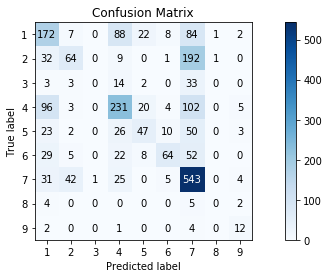

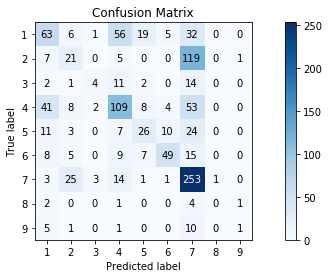

In [67]:
evaluate_features(truncated_bag_of_words, y_train, truncated_bag_of_words2, y_test)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.4s finished


Log loss of training set: 1.1823431227614996
Accuracy of training set: 0.6091850517784781


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished


Log loss of test set: 1.326395708210827
Accuracy of test set: 0.5287671232876713


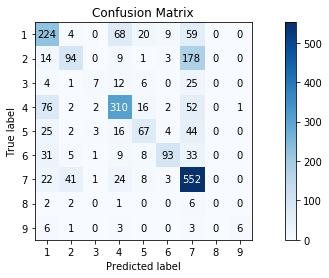

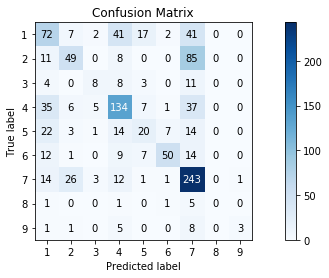

In [69]:
evaluate_features(truncated_bag_of_words, y_train, truncated_bag_of_words2, y_test, 
                  RandomForestClassifier(n_estimators=1000, max_depth=9, verbose=1))

Random Forest model is better than the logistic regression model both in log loss and model accuracy.

#### TFIDF

In [111]:
count_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.75, min_df=4)    

tfidf = count_vectorizer.fit_transform(df['Text'])

len(count_vectorizer.get_feature_names())


56300

#### Truncted SVD and TF-IDF

In [73]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf1 = svd.fit_transform(tfidf_train)
truncated_tfidf2 = svd.fit_transform(tfidf_test)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Log loss of training set: 1.396008210084452
Accuracy of training set: 0.4925709140027015


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished


Log loss of test set: 1.515921573148094
Accuracy of test set: 0.4611872146118721


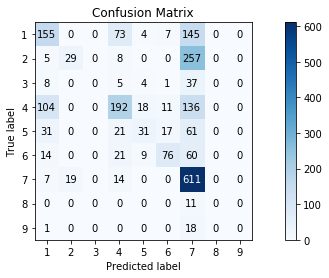

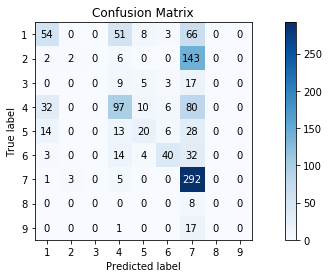

In [75]:
evaluate_features(truncated_tfidf1, y_train, truncated_tfidf2, y_test)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.0s finished


Log loss of training set: 1.1506099595322337
Accuracy of training set: 0.589824403421882


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.2s finished


Log loss of test set: 1.3364489293258033
Accuracy of test set: 0.4958904109589041


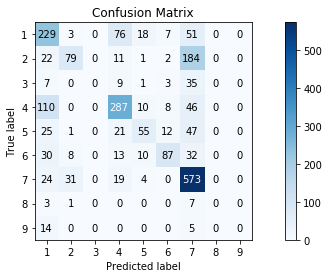

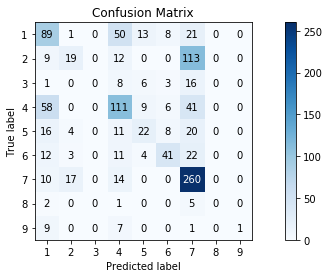

In [76]:
evaluate_features(truncated_tfidf1, y_train, truncated_tfidf2, y_test, 
                  RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_leaf=10,verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished


Log loss of training set: 1.350459083584947
Accuracy of training set: 0.5065285907248986


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished


Log loss of test set: 1.4314985327328322
Accuracy of test set: 0.4821917808219178


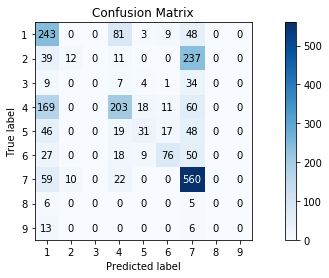

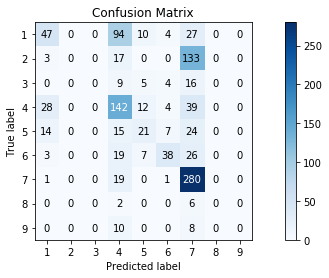

In [77]:
evaluate_features(truncated_tfidf1, y_train, truncated_tfidf2, y_test, 
                  SVC(kernel='linear', probability=True))

#### Summary:
In this part Truncted SVD with count vectorizer performs better than that with TF-IDF. But Truncted SVD with count vectorizer didn't perform better than the model without Truncted SVD.


### IV. Word2vec

This time, let's try the popular word2vec to get features.

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

In many cases traditional text classification can be difficult to scale, because as the order of the taxonomy count increases, the amount of training required increases as well. Moreover, with taxonomy counts in the thousands or tens of thousands, it can become increasingly expensive to gather a sufficient volume of labeled text examples for each taxonomic class.

One solution to this problem is to move to Word2Vec for the processing of your unstructured text data. Word2Vec (W2V) is an algorithm that takes every word in your vocabulary—that is, the text you are classifying—and turns it into a unique vector that can be added, subtracted, and manipulated in other ways just like a vector in space.

In [78]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model


Start training the word2vec model. Since word2vec training is unsupervised, you can use both training and test datasets.

If training has already been done, the function will just load the word2vec to disk so you don't need to retrain if rerunning the notebook.


In [83]:
w2vec = get_word2vec(
    MySentences(
        X_train.values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

Found w2vmodel


Now that we have our word2vec model, how do we use it to transform each documents into a feature vector? In order to convert a document of multiple words into a single vector using our trained word2vec, we take the word2vec of all words in the document, then take its mean.

We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector

In [84]:
import nltk
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


In [85]:

mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(X_train)


C:\Users\yepeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [86]:
w2vec = get_word2vec(
    MySentences(
        X_test.values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

Found w2vmodel


In [87]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded1 = mean_embedding_vectorizer.fit_transform(X_test)

C:\Users\yepeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished


Log loss of training set: 1.2508235971322528
Accuracy of training set: 0.5515533543448897


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished


Log loss of test set: 1.3665064056669463
Accuracy of test set: 0.5187214611872146


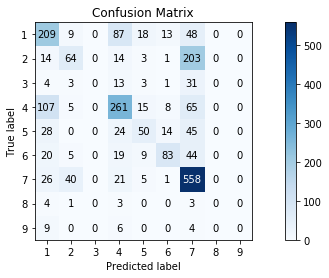

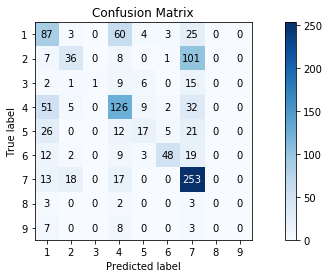

In [89]:
evaluate_features(mean_embedded, y_train, mean_embedded1, y_test)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.2s finished


Log loss of training set: 1.2043050604945094
Accuracy of training set: 0.6006303466906798


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.9s finished


Log loss of test set: 1.3665889524368535
Accuracy of test set: 0.5232876712328767


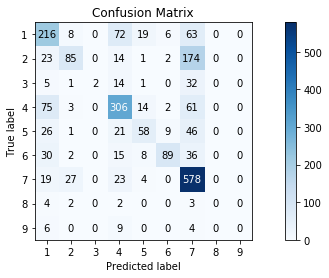

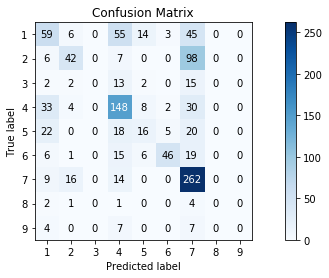

In [90]:
evaluate_features(mean_embedded, y_train, mean_embedded1, y_test,
                  RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_leaf=10,verbose=1))


As expected, we get better results than Truncted SVD with count vectorizer/TF-IDF. But the Random forest accuracy of word2vector is 0.52 while Random forest model with only TF-IDF in the first part is 0.54.

So the results are still not very good though. One way to explain this is that there is a lot of information loss from just getting the mean of all word vectors of the document. This is roughly analogous to taking the entire document, summarizing it into one word, and using that word to classify the entire text.


### V. LSTM

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Let's try a quick and dirty LSTM in Keras to take into account the sequential nature of text

•We won't do any hyperparameter search 

•We'll go with 15 epochs, and save the model with the best validation loss after an epoch

•Max sequence length is cut down to a measly 2000 (longest text has 77000+ words), to shorten training time


In [91]:
# import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [92]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['Text'].values)

In [93]:
# Pad the data 
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=2000)


In [94]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
Y = pd.get_dummies(df['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(2652, 2000) (2652, 9)
(664, 2000) (664, 9)


In [96]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 2121 samples, validate on 531 samples
Epoch 1/8
2121/2121 [==============================] - 2453s 1s/step - loss: 1.8661 - categorical_crossentropy: 1.8661 - val_loss: 1.7947 - val_categorical_crossentropy: 1.7947
Epoch 2/8
2121/2121 [==============================] - 2560s 1s/step - loss: 1.5246 - categorical_crossentropy: 1.5246 - val_loss: 1.4679 - val_categorical_crossentropy: 1.4679
Epoch 3/8
2121/2121 [==============================] - 2650s 1s/step - loss: 1.2096 - categorical_crossentropy: 1.2096 - val_loss: 1.4001 - val_categorical_crossentropy: 1.4001
Epoch 4/8
2121/2121 [==============================] - 2604s 1s/step - loss: 1.0219 - categorical_crossentropy: 1.0219 - val_loss: 1.4908 - val_categorical_crossentropy: 1.4908
Epoch 5/8
2121/2121 [==============================] - 2417s 1s/step - loss: 0.8990 - categorical_crossentropy: 0.8990 - val_loss: 1.5064 - val_categorical_crossentropy: 1.5064
Epoch 6/8
2121/2121 [==============================] - 2365s 1s/step

In [97]:
model = load_model('keras_model')

In [98]:
probas = model.predict(X_test)

Log loss: 1.3737221723955393
Accuracy: 0.49698795180722893


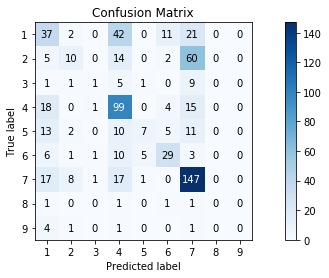

In [101]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.metrics.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)


The results of the quick LSTM are promising.

On the first try with no hyperparameter search, 6th epoch, max sequence length cut down to a measly 2000 (longest text has 77000+ words), we get the best log loss so far of around 1.37. 

Further tuning of the LSTM will likely produce better results.

So far, we've only used the text field to perform classification. But there is still the "Gene" and "Variation" fields.

Using only the Text field is a bit flawed. Looking closer at the statistics we calculated above, "training_text" actually has duplicates, and the duplicates have different classes. This is part of the challenge. A lot of papers are studies of 2 or more genes. It is our future job to use the other fields to figure out which parts of the text are relevant for the particular Gene and Variation.
